In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
device = 'cpu'
dtype = torch.float

def make_plot(space, **kwargs):
    grid = torch.stack([space, torch.zeros_like(space)], dim=-1)[None, None, :]
    input = torch.tensor([[[[2, 3]]]], dtype=dtype, device=device)
    r = torch.nn.functional.grid_sample(
        input,
        grid,
        **kwargs,
    ).flatten()

    plt.plot(space, r)
    plt.title(f'{kwargs}')
    plt.grid()
    ax = plt.gca()
    ticks = torch.linspace(space[0].item(), space[-1].item(), int((space[-1].item() - space[0].item()) / 0.5) + 1).tolist()
    ax.set_xticks(ticks)
    ax.tick_params(axis='x', labelrotation=90)
    plt.show()

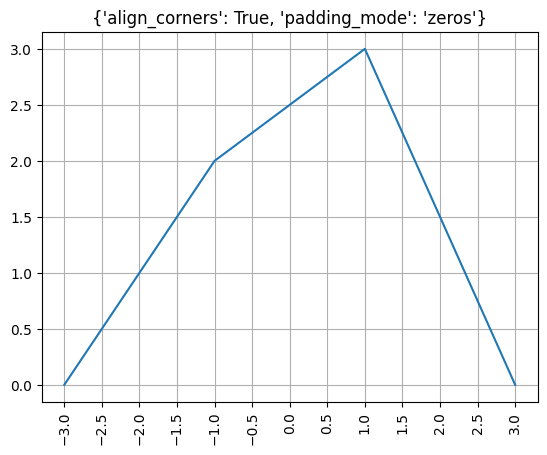

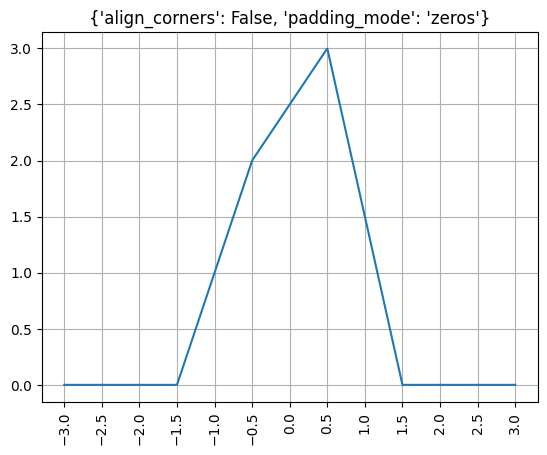

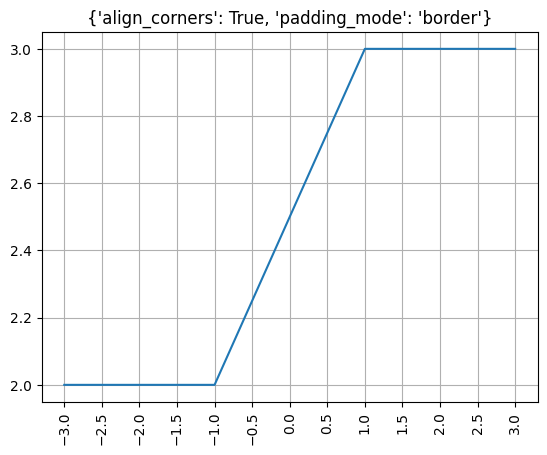

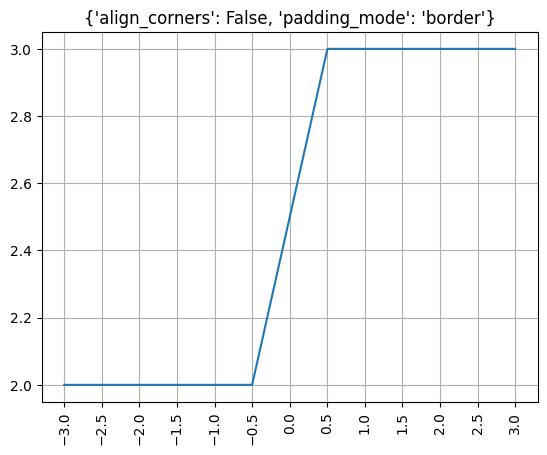

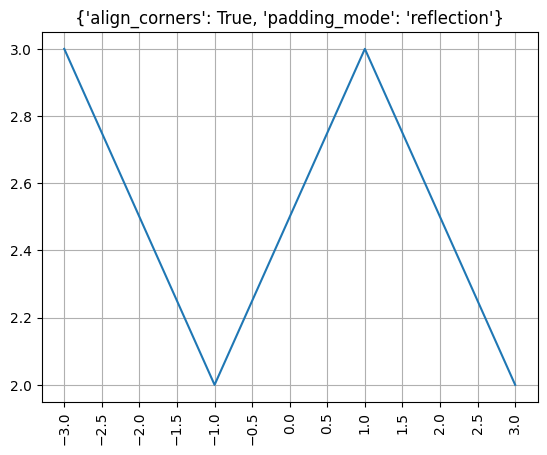

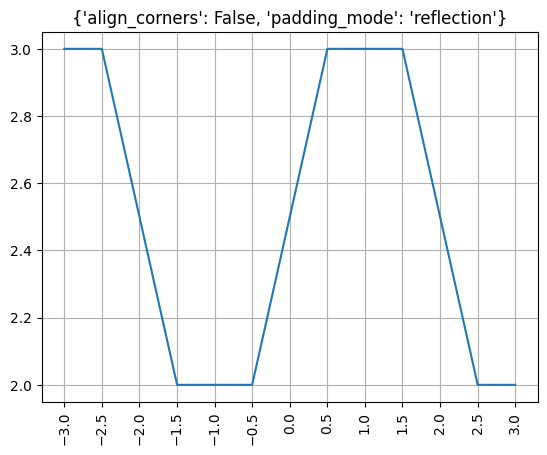

In [3]:
space = torch.linspace(-3, 3, 1000, dtype=torch.float, device=device)
make_plot(space, align_corners=True, padding_mode='zeros')
make_plot(space, align_corners=False, padding_mode='zeros')
make_plot(space, align_corners=True, padding_mode='border')
make_plot(space, align_corners=False, padding_mode='border')
make_plot(space, align_corners=True, padding_mode='reflection')
make_plot(space, align_corners=False, padding_mode='reflection')